In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Industries'), 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-05-13 to 2019-07-12 - 62


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

59


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
GDX,38,3.020378,4.264063,0.699027,25.226941,6.075660
GDXJ,38,2.751540,4.809142,0.563896,22.385513,6.657301
IHI,38,1.313774,1.871645,0.680734,10.878305,2.045544
ARKK,38,1.143830,3.934951,0.280600,10.917832,11.351589
XAR,38,1.008547,1.749223,0.553883,10.463289,2.376372
RYT,38,1.007562,2.463393,0.392905,11.201760,6.454069
XLK,38,0.982388,2.650075,0.355728,11.071736,7.053556
FXH,38,0.949558,1.858448,0.489589,8.294934,2.855186
XLB,38,0.938512,2.713812,0.331205,8.940789,4.056015


/Users/chaoyi/.local/share/virtualenvs/portfolio_analysis-bdMx2S3t/lib/python3.7/site-packages/scipy/optimize/optimize.py:2341: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/chaoyi/.local/share/virtualenvs/portfolio_analysis-bdMx2S3t/lib/python3.7/site-packages/scipy/optimize/optimize.py:1960: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


evicted EMLP 0.842 0.115
evicted IGF 0.877 0.322
evicted BOTZ 0.827 0.079
evicted VIS 0.889 0.235
evicted IXN 0.877 0.060
evicted FXU 0.879 -0.024
evicted VPU 0.703 -0.024
evicted IXJ 0.863 0.081
evicted XLP 0.817 0.062
evicted ITB 0.818 -0.024
evicted ITA 0.662 0.321
evicted SOXX 0.781 0.284
evicted XLE 0.775 0.269
evicted GUNR 0.736 0.328
evicted AMLP 0.737 -0.081
evicted XLB 0.719 0.051
evicted XLY 0.812 -0.009
evicted XLF 0.744 -0.094
evicted ARKK 0.724 -0.009
evicted XBI 0.544 0.010
evicted XLC 0.886 -0.238
retry backlogs ['FXL', 'VOX', 'VHT', 'IYH', 'XAR', 'XT', 'VCR', 'IGM', 'IYW', 'FDN', 'VGT', 'FTEC', 'FHLC', 'XLU', 'IYG', 'FBT', 'VAW', 'KBE', 'XLK', 'VDC', 'FNCL', 'XLI', 'VFH', 'QTEC', 'TDIV', 'RYT', 'GNR', 'SKYY', 'XLV', 'FXH', 'IBB', 'IGV', 'GDXJ', 'IYF', 'KRE'] at 0.905/-0.51 - 0.896
evicted XLI 0.895 0.293
evicted XLU 0.728 0.159
evicted VDC 0.823 0.034
evicted XAR 0.795 0.344
evicted FXH 0.893 0.207
evicted GNR 0.760 0.316
evicted VAW 0.732 0.092
evicted VCR 0.853 -0.021

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,38.0,1.840419,2.038508,-2.052275,0.354934,1.652219,3.112168,5.939511,0.883360,15.994604,2.052275
GDX,38.0,3.020378,4.264063,-6.075660,-0.267449,1.770037,5.922532,11.551582,0.699027,25.226941,6.075660
IHI,38.0,1.313774,1.871645,-1.336111,-0.001243,0.717746,2.646702,6.530127,0.680734,10.878305,2.045544
HACK,38.0,0.653962,2.544522,-5.318340,-1.168241,1.261638,2.352900,5.779099,0.241413,8.805127,8.159725


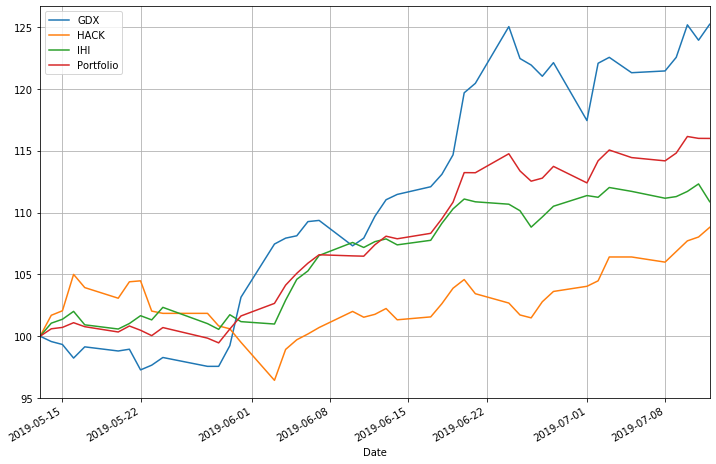

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=2)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=2))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)